# Deep Neural Networks
by Cesar Malenab

## Declarations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import time
import shap

import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.init

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import linear_model

shap.initjs()

pd.set_option('display.max_columns', None)

## Class and Function Definition

In [9]:
class FireResistanceDataset(Dataset):

    def __init__(self, device='cpu'):
        """Class constructor for the fire resistance of strengthened concrete beams dataset.
    
        Arguments:
            device {str} -- determines if cpu or gpu using cuda will be used for training/testing.
        """
        self.data = np.loadtxt('../data/fire_resistance.csv', 
                               delimiter=',',
                               usecols=range(1,17), #skip first column
                               dtype=np.float32,
                               skiprows=1)
        self.n_samples = self.data.shape[0]
        self.X = torch.from_numpy(self.data[:,:-1])
        self.y = torch.from_numpy(self.data[:,-1])
        self.device = device
        
    def __getitem__(self,index):
        """Extracts the data based on the given index.

        Arguments:
            index {int} -- row number of the data to be extracted.

        Returns:
            {tuple} -- contains tensors representing the features and target variable(fire resistance) of the dataset.
        """
        sample = self.X[index].to(self.device), self.y[index].to(self.device)
        return sample
    
    def __len__(self):
        """Shows the total number of rows in the dataset.

        Arguments:
            None

        Returns:
            int -- total number of rows in the dataset.
        """
        
        return self.n_samples
    
    def split_dataset(self, train_size, val_size, test_size, random_seed=None):
        """Perform a train-validation-test split for the dataset.

        Arguments:
            train_size {float} -- fraction of the training data in relation to the dataset.
            val_size {float} -- fraction of the validation data in relation to the dataset.
            test_size {float} -- fraction of the test data in relation to the dataset.
            random_seed {int} -- sets the condition for the random number generator 
            for reproducibility of the data split.

        Returns:
            {torch.utils.data.dataset.Subset} -- returns three datasets containing the training, 
            validation, and test sets.
            {list} -- returns three lists containing the indices of the randomized datasets. 
        """
        train_size = int(train_size * self.n_samples)
        val_size = int(val_size * self.n_samples)
        test_size = self.n_samples - train_size - val_size
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        train_set, val_set, test_set = random_split(self, [train_size, val_size, test_size])
        train_ids, val_ids, test_ids = train_set.indices, val_set.indices, test_set.indices
        
        return train_set, val_set, test_set, train_ids, val_ids, test_ids

In [7]:
#Experimental Dataset
class ExpFireResistanceDataset(Dataset):

    def __init__(self, device='cpu'):
        """Class constructor for the experimental data of the fire resistance dataset.
    
        Arguments:
            device {str} -- determines if cpu or gpu using cuda will be used for training/testing.
        """
        self.data = np.loadtxt('../data/fire_resistance.csv', 
                               delimiter=',',
                               usecols=range(1,17), #skip first column
                               dtype=np.float32,
                               skiprows=1,
                              max_rows=50) #get the experimental dataset only
        self.n_samples = self.data.shape[0]
        self.X = torch.from_numpy(self.data[:,:-1])
        self.y = torch.from_numpy(self.data[:,-1])
        self.device = device
        
    def __getitem__(self,index):
        """Extracts the data based on the given index.

        Arguments:
            index {int} -- row number of the data to be extracted.

        Returns:
            {tuple} -- contains tensors representing the features and target variable(fire resistance) of the dataset.
        """        
        sample = self.X[index].to(self.device), self.y[index].to(self.device)
        return sample
    
    def __len__(self):
        """Shows the total number of rows in the dataset.

        Arguments:
            None

        Returns:
            {int} -- total number of rows in the dataset.
        """        
        return self.n_samples
    
    def split_dataset(self, train_size, test_size, random_seed=None):
        """Perform a train-validation-test split for the dataset.

        Arguments:
            train_size {float} -- fraction of the training data in relation to the dataset.
            test_size {float} -- fraction of the test data in relation to the dataset.
            random_seed {int} -- sets the condition for the random number generator 
            for reproducibility of the data split.

        Returns:
            {torch.utils.data.dataset.Subset} -- returns two datasets containing the training, 
            and test sets
            {list} -- returns two lists containing the indices of the randomized datasets. 
        """        
        train_size = int(train_size * self.n_samples)
        test_size = self.n_samples - train_size
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        return random_split(self, [train_size, test_size])

In [125]:
class TorchStandardScaler:
    """Class constructor for standard scaler of torch tensors."""
    
    def fit(self, x):
        """Calculates the mean and standard deviation of the given tensors.

        Arguments:
            x {Torch.tensor} -- contains the train data by which the mean and 
            standard deviation will be calculated.

        Returns:
            None
        """
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True) #unbiased for Bessels correction
    def transform(self, x):
        """Scales the test data based on the mean and standard deviation of the train data.

        Arguments:
            x {Torch.tensor} -- contains the test data to be scaled.

        Returns:
            {Torch.tensor} -- returns the scaled test dataset.
        """
        x -= self.mean
        x /= (self.std + 1e-7) #1e-7 to avoid zero division
        return x

In [126]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, 
                 input_size,
                 output_size,
                 hidden_layers,
                 activation='relu',
                 p=0,
                 batch_norm=False,
                 init_method='he'):
        """Class constructor for the Neural Network.

        Arguments:
            input_size {int} -- Number of features in the dataset
            output_size {int} -- Number of classes in the dataset
            hidden_layers {list} -- List of integers representing the number of
            units per hidden layer in the network
            activation {str, optional} -- Type of activation function. Choices
            include 'sigmoid', 'tanh', and 'relu'. Default value is 'relu'.
            p {float} -- Dropout rate which randomly turns off neurons in the network.
            batch_norm {bool} -- Sets if batch normalization is activated or not.
            init_method {str, optional} -- Sets the initialization method for the weights
            and biases of the neurons.

        Returns:
            None
        """
        
        super(NeuralNetwork, self).__init__()
        
        layerlist = []
        self.input_size = input_size
        n_in = self.input_size
        
        for i in hidden_layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(self.get_activation(activation))
            if batch_norm:
                layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
            
        layerlist.append(nn.Linear(hidden_layers[-1], output_size))
        
        self.layers = nn.Sequential(*layerlist)
        
        self.init_weights(init_method)
        
    def get_activation(self, mode='relu'):
        """Returns the torch.nn layer for the activation function.

        Arguments:
            mode {str, optional} -- Type of activation function. Choices
            include 'sigmoid', 'tanh', and 'relu'. Default value is 'relu'.

        Returns:
            {torch.nn} -- torch.nn layer representing the activation function.
        """
        
        if mode == 'relu':
            activation = nn.ReLU(inplace=False) #setting to false to avoid error in shap
        elif mode == 'tanh':
            activation = nn.Tanh()
        elif mode == 'sigmoid':
            activation = nn.Sigmoid()
        elif mode == 'selu':
            activation = nn.SELU(inplace=True)
        elif mode == 'elu':
            activation = nn.ELU(inplace=True)
        else:
            raise ValueError("Invalid activation function. Supported functions: 'sigmoid', 'tanh', 'relu', 'selu', 'elu'.")
            
        return activation
    
    def init_weights(self, mode='he'): 
        """Initializes the weights and biases of the network. Bias terms are initialized with a constant value of 0.
        
        Arguments:
            mode {str} -- sets the initialization method of the neurons.
            
        Returns:
            None
        """
        
        for module in self.modules():
            
            if isinstance(module, nn.Linear):
                
                if mode == 'he':
                    nn.init.kaiming_uniform_(module.weight, mode='fan_in', nonlinearity='relu') 
                elif mode == 'lecun':
                    std = 1.0 / (self.input_size ** 0.5)  # Calculate the standard deviation
                    nn.init.normal_(module.weight, mean=0, std=std)
                elif mode =='xavier':
                    nn.init.xavier_normal_(module.weight)
                elif mode =='uniform':
                    nn.init.normal_(module.weight, mean=0, std=1)
                else:
                     raise ValueError("Invalid intialization method. Supported methods: 'he', 'lecun', 'uniform', 'xavier'.")
                
                #initial bias
                nn.init.constant_(module.bias, val=0)
                
    def forward(self, x):
        """Performs the forward propagation in the neural network.

        Arguments:
            x {torch.Tensor} -- A Tensor of shape (N, D) representing input
            features to the model.

        Returns:
            torch.Tensor -- A Tensor of shape (N, C) representing
            the output of the final linear layer in the network. 
        """
        x = self.layers(x)
        return x

In [127]:
def train_model(model, criterion, train_loader, validation_loader, optimizer, epochs=100):
    """Trains the neural network model and determines the training and validation loss 
    for a certain number of epochs.

        Arguments:
            model {NeuralNetwork} -- Neural network model to be trained. 
            criterion {torch.nn.Module} -- Loss function to be optimized. 
            train_loader {torch.utils.data.DataLoader} -- Data loader for the training dataset.
            validation_loader {torch.utils.data.DataLoader} -- Data loader for the validation dataset.
            optimizer {torch.optim.Optimizer} -- Optimizer to be used for updating the parameters of the
            model based on the calculated gradients. 
            epochs {int, optional} -- Number of epochs for which the model will be trained.


        Returns:
            {dict} -- dictionary containing the average training loss and validation loss
            for each epoch.
        """
    
    loss_record = {'training_loss':[], 'validation_loss':[]}
    
    for epoch in range(epochs):
        
        #training
        model.train()
        current_train_loss = 0
        current_val_loss = 0
        
        for X_train, y_train in train_loader:
            
            optimizer.zero_grad()
            yhat_train = model(X_train)
            train_loss = criterion(yhat_train, y_train.view(-1, 1)) #reshape train_data
            train_loss.backward()
            optimizer.step()
            current_train_loss += train_loss.item()
            
        average_train_loss = current_train_loss / len(train_loader)
        loss_record['training_loss'].append(average_train_loss)
        
        
        #validation
        model.eval()
        for X_val, y_val in validation_loader:
            yhat_val = model(X_val)
            val_loss = criterion(yhat_val, y_val.view(-1, 1))
            current_val_loss += val_loss.item()
            
        average_val_loss = current_val_loss / len(validation_loader)
        loss_record['validation_loss'].append(average_val_loss)
        
        print(f"Epoch: {epoch}\t Training Loss: {average_train_loss}\t Validation Loss:{val_loss} ")
        
    return loss_record

In [128]:
def train_model_exp(model, criterion, train_loader, optimizer, epochs=100):
    """Trains the neural network model and determines the training loss for a certain number of epochs.

        Arguments:
            model {NeuralNetwork} -- Neural network model to be trained. 
            criterion {torch.nn.Module} -- Loss function to be optimized. 
            train_loader {torch.utils.data.DataLoader} -- Data loader for the training dataset.
            validation_loader {torch.utils.data.DataLoader} -- Data loader for the validation dataset.
            optimizer {torch.optim.Optimizer} -- Optimizer to be used for updating the parameters of the
            model based on the calculated gradients. 
            epochs {int, optional} -- Number of epochs for which the model will be trained.


        Returns:
            {dict} -- dictionary containing the average training loss and validation loss
            for each epoch.
        """
    
    loss_record = {'training_loss':[], 'validation_loss':[]}
    
    for epoch in range(epochs):
        
        #training
        model.train()
        current_train_loss = 0
        current_val_loss = 0
        
        for X_train, y_train in train_loader:
            
            optimizer.zero_grad()
            yhat_train = model(X_train)
            train_loss = criterion(yhat_train, y_train.view(-1, 1)) #reshape train_data
            train_loss.backward()
            optimizer.step()
            current_train_loss += train_loss.item()
            
        average_train_loss = current_train_loss / len(train_loader)
        loss_record['training_loss'].append(average_train_loss)
        
        print(f"Epoch: {epoch}\t Training Loss: {average_train_loss}.")
        
    return loss_record

In [129]:
def test_model(model, criterion, test_loader):
    """Performs testing of the trained neural network model.

        Arguments:
            model {Neural Network} -- Neural network model to be tested.
            criterion {torch.nn.Module} -- Loss function to be computed for the test data.
            test_loader {torch.utils.data.DataLoader} -- Data loader for the testing dataset.

        Returns:
            None
        """
    
    current_test_loss = 0
    model.eval()
    
    for X_test, y_test in test_loader:
        yhat_test = model(X_test)
        test_loss = criterion(yhat_test, y_test.view(-1, 1))
        current_test_loss += test_loss.item()
        
    average_test_loss = current_test_loss / len(test_loader)
    
    return f"Test loss: {average_test_loss}"
        

In [130]:
def plot_losses(loss_record, epoch_start=1):
    """Plots the average training loss and validation loss of the model per epoch.

        Arguments:
            loss_record {dict} -- Contains the average training loss and validation loss
            of the neural network model.
            epoch_start {int} -- Epoch number where the plot of the losses will start.

        Returns:
            None
        """
    training_loss = loss_record['training_loss']
    validation_loss = loss_record['validation_loss']
    
    epochs = range(epoch_start, len(training_loss))
    plt.figure(figsize=(12, 8))
    plt.plot(epochs, training_loss[epoch_start:], 'b', label='Training loss')
    plt.plot(epochs, validation_loss[epoch_start:], 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show();

### Data Import

In [131]:
df = pd.read_csv('data/fire_resistance.csv')
df = df.set_index('beam_name')

In [132]:
df.head()

,length,concrete_area,concrete_cover,steel_area,frp_area,insulation_thickness,insulation_depth,conc_strength,steel_strength,frp_strength,glass_transition,thermal_conductivity,specific_heat,total_load,load_ratio,fire_resistance
beam_name,,,,,,,,,,,,,,,,
B1,3000,60000,25,402.1,0.0,0.0,0.0,47.6,591,0,0,0.000,0,61.2,44.8,90
B2,3000,60000,25,402.1,0.0,0.0,0.0,45.5,591,0,0,0.000,0,61.2,44.8,90
B3,3000,60000,25,402.1,120.0,25.0,0.0,44.4,591,2800,52,0.175,730800,81.2,38.4,76
B4,3000,60000,25,402.1,120.0,40.0,80.0,47.4,591,2800,52,0.175,730800,81.2,38.4,90
B5,3000,60000,25,402.1,120.0,25.0,80.0,45.1,591,2800,52,0.175,730800,81.2,38.4,92


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21434 entries, B1 to I5_ B4488
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   length                21434 non-null  int64  
 1   concrete_area         21434 non-null  int64  
 2   concrete_cover        21434 non-null  int64  
 3   steel_area            21434 non-null  float64
 4   frp_area              21434 non-null  float64
 5   insulation_thickness  21434 non-null  float64
 6   insulation_depth      21434 non-null  float64
 7   conc_strength         21434 non-null  float64
 8   steel_strength        21434 non-null  int64  
 9   frp_strength          21434 non-null  int64  
 10  glass_transition      21434 non-null  int64  
 11  thermal_conductivity  21434 non-null  float64
 12  specific_heat         21434 non-null  int64  
 13  total_load            21434 non-null  float64
 14  load_ratio            21434 non-null  float64
 15  fire_resistance    

### Dataset and Data Loader

In [10]:
dataset = FireResistanceDataset()

In [135]:
len(dataset)

21434

In [136]:
dataset[0] #unscaled values

(tensor([3.0000e+03, 6.0000e+04, 2.5000e+01, 4.0210e+02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 4.7600e+01, 5.9100e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 6.1200e+01, 4.4800e+01]),
 tensor(90.))

In [11]:
train_dataset, val_dataset, test_dataset, train_id, val_id, test_id = dataset.split_dataset(0.8,0.10,0.10, random_seed=84)

In [150]:
len(train_dataset) + len(val_dataset) + len(test_dataset)

21434

In [151]:
for i in range(1):
    train = train_dataset[i]
    test = val_dataset[i]
    val = test_dataset[i]
    print(train)
    print(test)
    print(val)

(tensor([2.4600e+03, 1.2000e+04, 1.0000e+01, 6.3310e+01, 1.5300e+01, 3.8000e+01,
        3.0000e+01, 2.9000e+01, 4.5200e+02, 1.1380e+03, 8.6000e+01, 8.6000e-02,
        3.9500e+05, 8.2100e+00, 7.0210e+01]), tensor(45.))
(tensor([2.3800e+03, 1.0500e+05, 2.5000e+01, 3.7984e+02, 3.9100e+01, 1.9000e+01,
        7.5000e+01, 2.9000e+01, 4.5300e+02, 4.8400e+03, 7.7000e+01, 1.1600e-01,
        1.0050e+06, 1.4183e+02, 6.1590e+01]), tensor(35.))
(tensor([5.3000e+03, 1.5750e+05, 2.5000e+01, 5.6976e+02, 2.5500e+02, 3.8000e+01,
        5.0000e+01, 2.8000e+01, 4.2300e+02, 1.0680e+03, 8.2000e+01, 3.8000e-02,
        2.8900e+05, 7.0680e+01, 7.0140e+01]), tensor(75.))


Scaling the dataset using standardscaler:

In [152]:
scaler = TorchStandardScaler()

In [153]:
scaler.fit(train_dataset[:len(train_dataset)][0])

In [154]:
train_dataset = TensorDataset(scaler.transform(train_dataset[:len(train_dataset)][0]), 
                              train_dataset[:len(train_dataset)][1])

val_dataset = TensorDataset(scaler.transform(val_dataset[:len(val_dataset)][0]), 
                            val_dataset[:len(val_dataset)][1])

test_dataset = TensorDataset(scaler.transform(test_dataset[:len(test_dataset)][0]), 
                             test_dataset[:len(test_dataset)][1])

In [155]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=512,
                          shuffle=True)

validation_loader = DataLoader(dataset=val_dataset,
                               batch_size=len(val_dataset),
                               shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)
                          

In [156]:
next(iter(train_loader))

[tensor([[ 1.4151,  0.0356,  1.1925,  ..., -0.3898, -0.8559,  1.2634],
         [-0.8460, -1.7638, -1.6922,  ...,  0.0377, -1.5345, -0.6701],
         [-1.0230,  0.0356, -0.1468,  ...,  1.7228,  1.2007,  0.1978],
         ...,
         [ 0.4888,  1.2352,  1.1925,  ..., -1.8798, -0.1412,  0.2413],
         [-0.8732, -1.1640, -1.4861,  ...,  0.9716, -0.7116,  1.2067],
         [ 1.8101,  1.2352,  1.1925,  ..., -0.7094, -0.6165, -0.9977]]),
 tensor([ 95.,  45.,  65.,  45.,  50.,  95., 300.,  35., 165., 185.,  55.,  35.,
          55., 190.,  30.,  60., 225., 200., 145.,  45.,  75., 145., 110.,  50.,
          40.,  40.,  30., 110.,  55.,  75.,  40., 250.,  25., 235., 130.,  50.,
          80., 170.,  65.,  60., 230., 235.,  25.,  95.,  15.,  60.,  35.,  45.,
         130.,  80.,  35.,  55., 170., 105., 225.,  60.,  25., 115., 165., 255.,
          80., 130., 135.,  70.,  15.,  60., 175., 165.,  20.,  50.,  30.,  50.,
          40., 120.,  40.,  30.,  45.,  70.,  60.,  65.,  35.,  50., 165

## Deep Neural Network

#### Sample model initialization

In [874]:
model = NeuralNetwork(input_size=15,
                      output_size=1,
                      hidden_layers=[100,100,100,100], 
                      activation='selu', 
                      p=0.2, 
                      batch_norm=False,
                     init_method='lecun')

In [875]:
print(model)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=100, bias=True)
    (1): SELU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): SELU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): SELU(inplace=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=100, out_features=100, bias=True)
    (10): SELU(inplace=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=100, out_features=1, bias=True)
  )
)


#### Weights

In [876]:
model.layers[9].weight

Parameter containing:
tensor([[ 0.5188, -0.2982,  0.1663,  ...,  0.0314,  0.0112,  0.0615],
        [ 0.1144, -0.2655, -0.0128,  ..., -0.2334, -0.4303, -0.1055],
        [-0.1610, -0.3897, -0.2049,  ..., -0.1864,  0.2639,  0.1797],
        ...,
        [-0.1189, -0.0575, -0.1187,  ..., -0.1769,  0.1992,  0.0540],
        [ 0.3872, -0.3046,  0.0497,  ..., -0.2096,  0.0126, -0.3426],
        [ 0.0049,  0.1466,  0.3065,  ...,  0.0490, -0.3778, -0.1855]],
       requires_grad=True)

#### Biases

In [40]:
model.layers[0].bias

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], requires_grad=True)

### Application

#### Model

In [991]:
model = NeuralNetwork(input_size=15,
                      output_size=1,
                      hidden_layers=[200, 300, 200], 
                      activation='relu', 
                      p=0.25, 
                      batch_norm=True,
                      init_method='he')

epochs = 700
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

print(model)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=200, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=200, out_features=300, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=300, out_features=200, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.25, inplace=False)
    (12): Linear(in_features=200, out_features=1, bias=True)
  )
)


In [992]:
start_time = time.time()

loss_record = train_model(model = model, 
                          criterion = criterion, 
                          train_loader = train_loader, 
                          validation_loader = validation_loader, 
                          optimizer = optimizer, 
                          epochs = epochs)

duration = time.time() - start_time
print(f"Training took {duration/60} minutes.")

Epoch: 0	 Training Loss: 14597.940630744486	 Validation Loss:13461.341796875 
Epoch: 1	 Training Loss: 13192.97616038603	 Validation Loss:12935.3525390625 
Epoch: 2	 Training Loss: 12044.25700827206	 Validation Loss:11951.1787109375 
Epoch: 3	 Training Loss: 11029.261919806986	 Validation Loss:10943.3740234375 
Epoch: 4	 Training Loss: 10077.972397748163	 Validation Loss:10045.0234375 
Epoch: 5	 Training Loss: 9215.0263671875	 Validation Loss:9330.2744140625 
Epoch: 6	 Training Loss: 8451.848963120405	 Validation Loss:8250.6376953125 
Epoch: 7	 Training Loss: 7696.013571346507	 Validation Loss:7275.48388671875 
Epoch: 8	 Training Loss: 6937.37739832261	 Validation Loss:6495.29931640625 
Epoch: 9	 Training Loss: 6184.151884191177	 Validation Loss:5654.599609375 
Epoch: 10	 Training Loss: 5362.553237017463	 Validation Loss:4868.53173828125 
Epoch: 11	 Training Loss: 4552.931999655331	 Validation Loss:3841.0009765625 
Epoch: 12	 Training Loss: 3817.992560891544	 Validation Loss:3393.39892

Epoch: 104	 Training Loss: 604.6130801930148	 Validation Loss:447.5701904296875 
Epoch: 105	 Training Loss: 599.1520987117992	 Validation Loss:439.435302734375 
Epoch: 106	 Training Loss: 584.7706038531135	 Validation Loss:438.4791259765625 
Epoch: 107	 Training Loss: 586.0239904067096	 Validation Loss:441.8088684082031 
Epoch: 108	 Training Loss: 587.8807830810547	 Validation Loss:435.0911560058594 
Epoch: 109	 Training Loss: 580.4052303538602	 Validation Loss:435.5277099609375 
Epoch: 110	 Training Loss: 578.6395891974954	 Validation Loss:424.7417907714844 
Epoch: 111	 Training Loss: 586.1863062241498	 Validation Loss:436.969970703125 
Epoch: 112	 Training Loss: 578.2696048512179	 Validation Loss:435.2329406738281 
Epoch: 113	 Training Loss: 594.5132132137524	 Validation Loss:428.259033203125 
Epoch: 114	 Training Loss: 579.3297325583065	 Validation Loss:426.7478942871094 
Epoch: 115	 Training Loss: 593.0767831241383	 Validation Loss:423.36834716796875 
Epoch: 116	 Training Loss: 565

Epoch: 206	 Training Loss: 449.3288215188419	 Validation Loss:354.7491149902344 
Epoch: 207	 Training Loss: 453.99250075396367	 Validation Loss:348.216064453125 
Epoch: 208	 Training Loss: 461.707961138557	 Validation Loss:345.74468994140625 
Epoch: 209	 Training Loss: 453.30745741900273	 Validation Loss:357.13165283203125 
Epoch: 210	 Training Loss: 453.65250800637637	 Validation Loss:346.21954345703125 
Epoch: 211	 Training Loss: 450.5645015940947	 Validation Loss:344.6328125 
Epoch: 212	 Training Loss: 443.70755094640396	 Validation Loss:342.4018859863281 
Epoch: 213	 Training Loss: 444.21078132180605	 Validation Loss:335.4312744140625 
Epoch: 214	 Training Loss: 433.176191442153	 Validation Loss:332.4397888183594 
Epoch: 215	 Training Loss: 448.97433381922104	 Validation Loss:344.1056213378906 
Epoch: 216	 Training Loss: 447.3212073830997	 Validation Loss:346.9712219238281 
Epoch: 217	 Training Loss: 472.8931283389821	 Validation Loss:345.9571838378906 
Epoch: 218	 Training Loss: 4

Epoch: 307	 Training Loss: 386.77677827722886	 Validation Loss:324.9956359863281 
Epoch: 308	 Training Loss: 387.5218443029067	 Validation Loss:323.477294921875 
Epoch: 309	 Training Loss: 395.4628017649931	 Validation Loss:320.2854309082031 
Epoch: 310	 Training Loss: 388.0542261460248	 Validation Loss:312.9434814453125 
Epoch: 311	 Training Loss: 412.87714161592373	 Validation Loss:324.0587158203125 
Epoch: 312	 Training Loss: 388.8868300494026	 Validation Loss:313.489501953125 
Epoch: 313	 Training Loss: 389.2207515940947	 Validation Loss:319.4311218261719 
Epoch: 314	 Training Loss: 397.0349910960478	 Validation Loss:319.2756042480469 
Epoch: 315	 Training Loss: 377.215035831227	 Validation Loss:328.1397399902344 
Epoch: 316	 Training Loss: 381.69254168342144	 Validation Loss:337.292236328125 
Epoch: 317	 Training Loss: 381.53330006318936	 Validation Loss:341.2364501953125 
Epoch: 318	 Training Loss: 389.21163222369023	 Validation Loss:336.75201416015625 
Epoch: 319	 Training Loss:

Epoch: 408	 Training Loss: 349.30481136546416	 Validation Loss:318.150634765625 
Epoch: 409	 Training Loss: 361.8391867244945	 Validation Loss:306.2088928222656 
Epoch: 410	 Training Loss: 366.09052141974956	 Validation Loss:312.07781982421875 
Epoch: 411	 Training Loss: 360.56269612031826	 Validation Loss:313.2724609375 
Epoch: 412	 Training Loss: 361.89806231330425	 Validation Loss:322.0375061035156 
Epoch: 413	 Training Loss: 350.62342744715073	 Validation Loss:305.4184265136719 
Epoch: 414	 Training Loss: 364.4514788459329	 Validation Loss:311.8583984375 
Epoch: 415	 Training Loss: 353.5351023954504	 Validation Loss:303.12896728515625 
Epoch: 416	 Training Loss: 356.75480203067553	 Validation Loss:318.1601257324219 
Epoch: 417	 Training Loss: 353.3110566980699	 Validation Loss:302.20526123046875 
Epoch: 418	 Training Loss: 349.9612606272978	 Validation Loss:302.29046630859375 
Epoch: 419	 Training Loss: 353.87499820484834	 Validation Loss:318.2684020996094 
Epoch: 420	 Training Los

Epoch: 509	 Training Loss: 338.23428703756895	 Validation Loss:297.3916320800781 
Epoch: 510	 Training Loss: 330.9687006333295	 Validation Loss:298.0939025878906 
Epoch: 511	 Training Loss: 343.1386588601505	 Validation Loss:300.6954650878906 
Epoch: 512	 Training Loss: 335.929282244514	 Validation Loss:306.1497497558594 
Epoch: 513	 Training Loss: 338.853323543773	 Validation Loss:309.5822448730469 
Epoch: 514	 Training Loss: 325.9113984949449	 Validation Loss:294.6800537109375 
Epoch: 515	 Training Loss: 340.7065645105699	 Validation Loss:306.7132873535156 
Epoch: 516	 Training Loss: 324.80199297736675	 Validation Loss:308.00506591796875 
Epoch: 517	 Training Loss: 340.88284032485063	 Validation Loss:301.4959716796875 
Epoch: 518	 Training Loss: 327.6961445527918	 Validation Loss:301.56939697265625 
Epoch: 519	 Training Loss: 328.06437458711514	 Validation Loss:308.384765625 
Epoch: 520	 Training Loss: 346.07625534955196	 Validation Loss:306.3302001953125 
Epoch: 521	 Training Loss: 

Epoch: 610	 Training Loss: 332.77186494715073	 Validation Loss:306.3007507324219 
Epoch: 611	 Training Loss: 321.05612766041475	 Validation Loss:316.1062316894531 
Epoch: 612	 Training Loss: 323.9239784689511	 Validation Loss:314.7626953125 
Epoch: 613	 Training Loss: 323.2293140186983	 Validation Loss:298.44317626953125 
Epoch: 614	 Training Loss: 324.67311365464155	 Validation Loss:320.99847412109375 
Epoch: 615	 Training Loss: 329.2126334695255	 Validation Loss:313.7239685058594 
Epoch: 616	 Training Loss: 315.5669044045841	 Validation Loss:302.50787353515625 
Epoch: 617	 Training Loss: 308.4716208962833	 Validation Loss:304.52276611328125 
Epoch: 618	 Training Loss: 314.5796957576976	 Validation Loss:299.794677734375 
Epoch: 619	 Training Loss: 321.26470274083755	 Validation Loss:291.2523498535156 
Epoch: 620	 Training Loss: 324.0368064431583	 Validation Loss:291.00830078125 
Epoch: 621	 Training Loss: 316.31620339786303	 Validation Loss:299.561767578125 
Epoch: 622	 Training Loss:

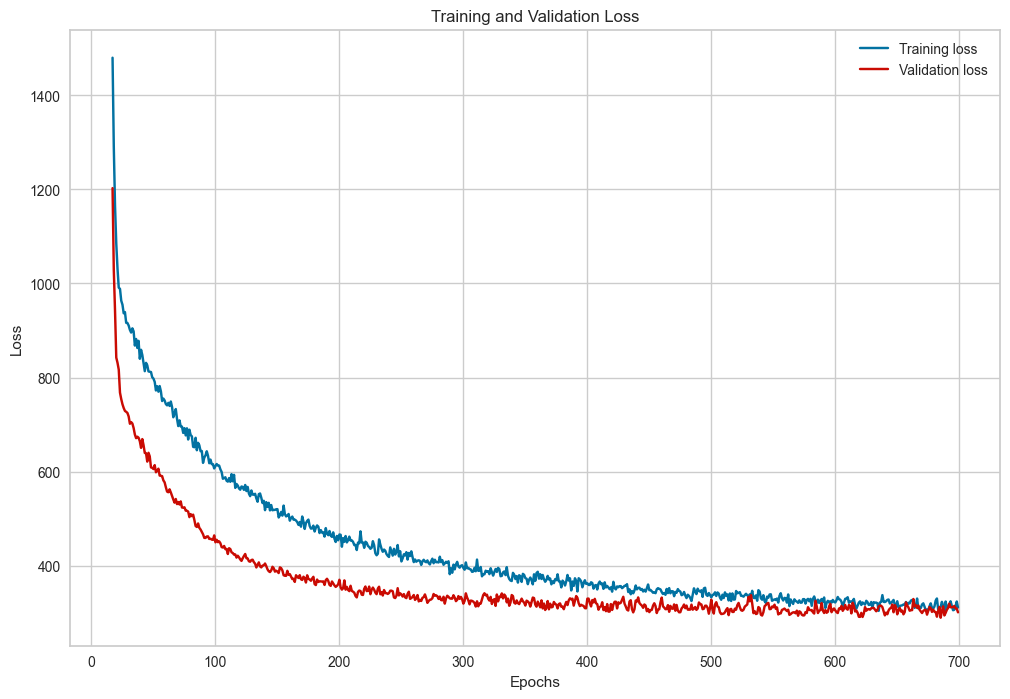

'Test loss: 375.7101135253906'

In [1000]:
plot_losses(loss_record, epoch_start=17)
test_model(model=model, criterion=criterion, test_loader=test_loader)

In [1001]:
#Saving the model
torch.save(model.state_dict(), 'fire_model.pt')

In [259]:
#loading the model

model = NeuralNetwork(input_size=15,
                      output_size=1,
                      hidden_layers=[200, 300, 200], 
                      activation='relu', 
                      p=0.25, 
                      batch_norm=True,
                      init_method='he')


model.load_state_dict(torch.load('fire_model.pt'))

<All keys matched successfully>

In [260]:
X_test, y_test = next(iter(test_loader))

y_pred_test = model(X_test)

In [261]:
RMSE_test = np.sqrt(mean_squared_error(y_test.detach().numpy(), y_pred_test.detach().numpy()))
MAE_test = mean_absolute_error(y_test.detach().numpy(), y_pred_test.detach().numpy())
r2_test = r2_score(y_test.detach().numpy(), y_pred_test.detach().numpy())

print(f"MAE: {MAE_test}")
print(f"RMSE: {RMSE_test}")
print(f"r2: {r2_test}")

MAE: 12.009135246276855
RMSE: 17.463958740234375
r2: 0.943224138769351


### Deep Neural Network Prediction Error

In [262]:
best_fit = linear_model.LinearRegression()
best_fit.fit(y_test.detach().numpy().reshape(-1,1), y_pred_test.detach().numpy())

LinearRegression()

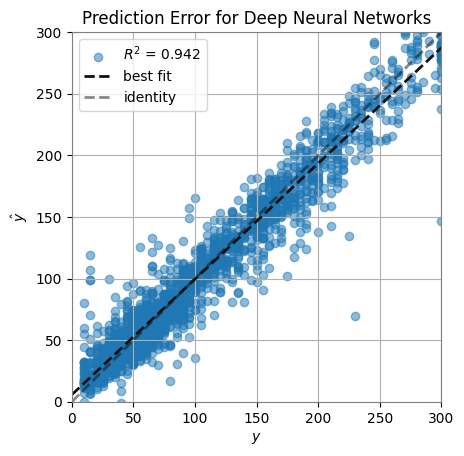

In [239]:
x=np.linspace(0,300, num=100).reshape(-1,1)

plt.scatter(y_test.detach().numpy(), y_pred_test.detach().numpy(), alpha=0.5, label=f"$R^2$ = {r2_test:0.3f}")
plt.plot(x, best_fit.predict(x), lw=2, ls="--", color='#111111', label='best fit')
plt.plot([0,300], [0,300], lw=2, ls="--", color='#111111', alpha=0.5, label='identity')

ax = plt.gca()
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.ylabel(r"$\hat{y}$")
plt.xlabel(r"$y$")
plt.title("Prediction Error for Deep Neural Networks")
plt.legend(loc="best", frameon=True)
ax.set_aspect("equal", adjustable="box")
ax.grid(True)
ax.spines['top'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
plt.show();

### Deep Neural Network Residual Plots

In [241]:
X_train = train_dataset[:len(train_dataset)][0]
y_train = train_dataset[:len(train_dataset)][1].detach().numpy().reshape(-1,1)

In [242]:
y_pred_train = model(X_train)

r2_train = r2_score(y_train, y_pred_train.detach().numpy())

In [243]:
r2_train

0.9370700351549576

In [244]:
residuals_train = y_pred_train.detach().numpy() - y_train

In [245]:
residuals_test = y_pred_test.detach().numpy() - y_test.detach().numpy().reshape(-1,1)

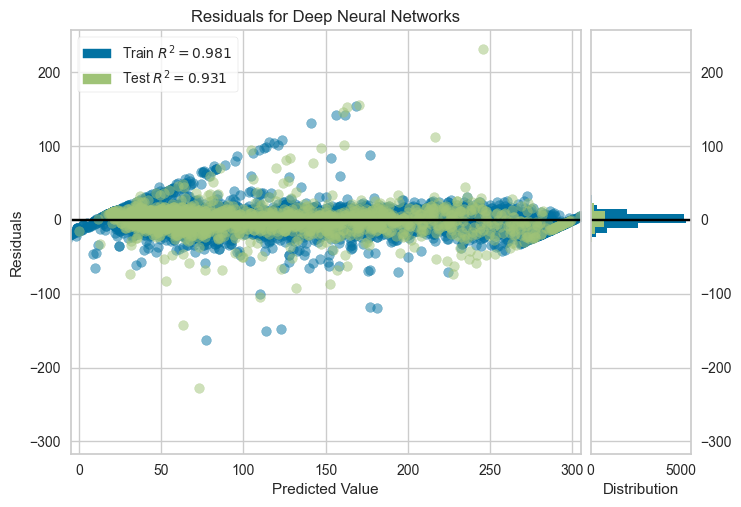

In [1021]:
label_train = f"Train $R^2 = {r2_train:0.3f}$"
label_test = f"Test $R^2 = {r2_test:0.3f}$"

plt.scatter(y_pred_train.detach().numpy(),
           residuals_train,
           alpha=0.5,
           color='b',
           label = label_train)

plt.scatter(y_pred_test.detach().numpy(),
           residuals_test,
           alpha=0.5,
           color='g',
           label = label_test)

ax = plt.gca()
ax.axhline(y=0, c='black')
ax.set_xlim(-5,305)
ax.set_ylabel("Residuals")
ax.set_xlabel("Predicted Value")
ax.set_title("Residuals for Deep Neural Networks")
handles = [
    patches.Patch(color=color, label=label) for color, label in [('b',label_train),('g',label_test)]
]
plt.legend(handles=handles, loc="best", frameon=True)


#Adding histogram of residuals
divider = make_axes_locatable(ax)
hax = divider.append_axes("right", size=1, pad=0.1, sharey=ax)
hax.yaxis.tick_right()
hax.grid(False, axis="x")
hax.hist(residuals_train, bins=50, orientation="horizontal", color='b')
hax.hist(residuals_test, bins=50, orientation="horizontal", color='g')
hax.set_xlabel("Distribution")
hax.axhline(y=0, c='black')


plt.show();

### Using SHAP for feature importance of Deep Neural Network

In [268]:
X_train_tensor = next(iter(train_loader))[0]

X_train_tensor = X_train_tensor[:100,:]

len(X_train_tensor)

100

In [269]:
X_test_tensor = next(iter(test_loader))[0]

X_test_tensor = X_test_tensor[:500,:]

len(X_test_tensor)

500

In [270]:
explainer = shap.DeepExplainer(model, data=X_train_tensor)
shap_values = explainer.shap_values(X_test_tensor)

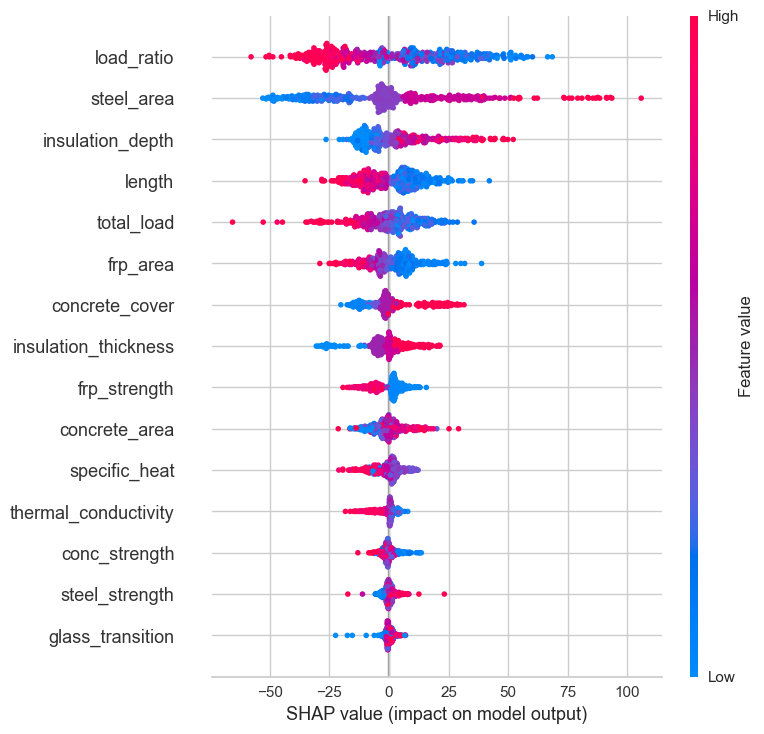

In [1015]:
shap.summary_plot(np.squeeze(shap_values), X_test_tensor, feature_names=df.columns[:-1])

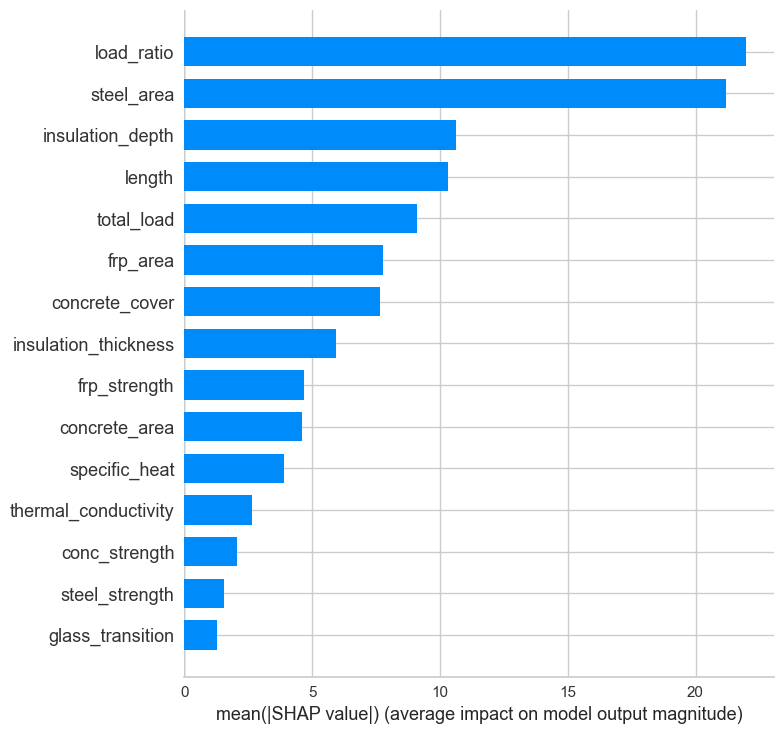

In [1016]:
shap.summary_plot(np.squeeze(shap_values), X_test_tensor, feature_names=df.columns[:-1], plot_type='bar')

### Deep Neural Network Experimental Data

In [54]:
dataset_exp = ExpFireResistanceDataset()

In [55]:
len(dataset_exp)

50

In [56]:
dataset_exp[45:]

(tensor([[3.6600e+03, 1.2573e+05, 3.8000e+01, 6.0320e+02, 1.7340e+02, 0.0000e+00,
          0.0000e+00, 4.2000e+01, 4.4000e+02, 1.0340e+03, 8.2000e+01, 0.0000e+00,
          5.1000e+05, 9.8000e+01, 5.1000e+01],
         [3.6600e+03, 1.2573e+05, 3.8000e+01, 6.0320e+02, 1.7340e+02, 2.5000e+01,
          7.5000e+01, 4.2000e+01, 4.4000e+02, 1.0340e+03, 8.2000e+01, 1.5600e-01,
          5.1000e+05, 9.8000e+01, 5.1000e+01],
         [3.6600e+03, 1.2573e+05, 3.8000e+01, 6.0320e+02, 1.7340e+02, 1.9000e+01,
          1.1200e+02, 4.2000e+01, 4.4000e+02, 1.0340e+03, 8.2000e+01, 1.5600e-01,
          5.1000e+05, 1.1600e+02, 6.1000e+01],
         [3.6600e+03, 1.2573e+05, 3.8000e+01, 6.0320e+02, 1.0200e+02, 3.2000e+01,
          1.5200e+02, 4.6000e+01, 4.6000e+02, 1.1720e+03, 8.2000e+01, 1.5600e-01,
          5.1000e+05, 9.7000e+01, 5.1000e+01],
         [3.6600e+03, 1.2573e+05, 3.8000e+01, 8.9800e+02, 1.0200e+02, 1.9000e+01,
          1.5200e+02, 4.6000e+01, 4.5000e+02, 1.1720e+03, 8.2000e+01, 1.56

In [87]:
train_dataset_exp, test_dataset_exp = dataset_exp.split_dataset(0.8,0.20, random_seed=101)

In [88]:
len(train_dataset_exp) + len(test_dataset_exp)

50

In [89]:
scaler_exp = TorchStandardScaler()

scaler_exp.fit(train_dataset_exp[:len(train_dataset_exp)][0])

In [90]:
train_dataset_exp = TensorDataset(scaler_exp.transform(train_dataset_exp[:len(train_dataset_exp)][0]), 
                              train_dataset_exp[:len(train_dataset_exp)][1])

test_dataset_exp = TensorDataset(scaler_exp.transform(test_dataset_exp[:len(test_dataset_exp)][0]), 
                             test_dataset_exp[:len(test_dataset_exp)][1])

In [91]:
train_loader_exp = DataLoader(dataset=train_dataset_exp,
                          batch_size=25,
                          shuffle=True)

test_loader_exp = DataLoader(dataset=test_dataset_exp,
                         batch_size=len(test_dataset_exp),
                         shuffle=False)
                          

Parameters from [Fire Performance of FRP-strengthened Concrete Flexural Members](https://d.lib.msu.edu/etd/50128):

**Deep Neural Networks**
* 2 hidden layers(26, 7 neurons)
* Lecun normal techinque intialization
* SELU activation function
* 1000 epochs
* batch size=25
* MSE criterion

In [92]:
model_exp = NeuralNetwork(input_size=15,
                      output_size=1,
                      hidden_layers=[26, 7], 
                      activation='selu', 
                      p=0, 
                      batch_norm=False,
                      init_method='lecun')

epochs = 1000
learning_rate = 0.001

optimizer = torch.optim.Adam(model_exp.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

print(model_exp)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=26, bias=True)
    (1): SELU(inplace=True)
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=26, out_features=7, bias=True)
    (4): SELU(inplace=True)
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=7, out_features=1, bias=True)
  )
)


In [93]:
start_time = time.time()

loss_record_exp = train_model_exp(model = model_exp, 
                                  criterion = criterion, 
                                  train_loader = train_loader_exp, 
                                  optimizer = optimizer, 
                                  epochs = epochs)

duration = time.time() - start_time
print(f"Training took {duration/60} minutes.")

Epoch: 0	 Training Loss: 15279.61474609375.
Epoch: 1	 Training Loss: 14415.51611328125.
Epoch: 2	 Training Loss: 14820.52490234375.
Epoch: 3	 Training Loss: 15392.5927734375.
Epoch: 4	 Training Loss: 14989.48193359375.
Epoch: 5	 Training Loss: 14859.66259765625.
Epoch: 6	 Training Loss: 15217.93115234375.
Epoch: 7	 Training Loss: 15011.48779296875.
Epoch: 8	 Training Loss: 15467.796875.
Epoch: 9	 Training Loss: 15170.90673828125.
Epoch: 10	 Training Loss: 14538.70947265625.
Epoch: 11	 Training Loss: 15615.0107421875.
Epoch: 12	 Training Loss: 14892.21337890625.
Epoch: 13	 Training Loss: 15101.90771484375.
Epoch: 14	 Training Loss: 15890.8154296875.
Epoch: 15	 Training Loss: 15263.23876953125.
Epoch: 16	 Training Loss: 15755.5615234375.
Epoch: 17	 Training Loss: 14835.060546875.
Epoch: 18	 Training Loss: 14595.91259765625.
Epoch: 19	 Training Loss: 15618.76220703125.
Epoch: 20	 Training Loss: 15186.15576171875.
Epoch: 21	 Training Loss: 15047.923828125.
Epoch: 22	 Training Loss: 16567.9

Epoch: 196	 Training Loss: 5574.539306640625.
Epoch: 197	 Training Loss: 5592.855712890625.
Epoch: 198	 Training Loss: 5304.769775390625.
Epoch: 199	 Training Loss: 5156.14453125.
Epoch: 200	 Training Loss: 5376.3896484375.
Epoch: 201	 Training Loss: 5371.531494140625.
Epoch: 202	 Training Loss: 5176.439697265625.
Epoch: 203	 Training Loss: 5203.852294921875.
Epoch: 204	 Training Loss: 4980.741943359375.
Epoch: 205	 Training Loss: 5394.4697265625.
Epoch: 206	 Training Loss: 5537.6533203125.
Epoch: 207	 Training Loss: 4606.541015625.
Epoch: 208	 Training Loss: 5060.083251953125.
Epoch: 209	 Training Loss: 5305.261962890625.
Epoch: 210	 Training Loss: 5010.63916015625.
Epoch: 211	 Training Loss: 4656.22119140625.
Epoch: 212	 Training Loss: 4713.7412109375.
Epoch: 213	 Training Loss: 4482.286865234375.
Epoch: 214	 Training Loss: 4556.935546875.
Epoch: 215	 Training Loss: 4488.017822265625.
Epoch: 216	 Training Loss: 4384.8134765625.
Epoch: 217	 Training Loss: 4186.202392578125.
Epoch: 218

Epoch: 411	 Training Loss: 1358.4788208007812.
Epoch: 412	 Training Loss: 1357.3673706054688.
Epoch: 413	 Training Loss: 1543.9501953125.
Epoch: 414	 Training Loss: 1532.3171997070312.
Epoch: 415	 Training Loss: 1380.6172485351562.
Epoch: 416	 Training Loss: 1381.7352294921875.
Epoch: 417	 Training Loss: 1400.9526977539062.
Epoch: 418	 Training Loss: 1421.474609375.
Epoch: 419	 Training Loss: 1432.0669555664062.
Epoch: 420	 Training Loss: 1589.041748046875.
Epoch: 421	 Training Loss: 1500.9973754882812.
Epoch: 422	 Training Loss: 1288.8778686523438.
Epoch: 423	 Training Loss: 1703.684814453125.
Epoch: 424	 Training Loss: 1387.1865234375.
Epoch: 425	 Training Loss: 1359.6270751953125.
Epoch: 426	 Training Loss: 1406.19580078125.
Epoch: 427	 Training Loss: 1279.4929504394531.
Epoch: 428	 Training Loss: 1319.4149169921875.
Epoch: 429	 Training Loss: 1412.8740844726562.
Epoch: 430	 Training Loss: 1405.3942260742188.
Epoch: 431	 Training Loss: 1347.0020141601562.
Epoch: 432	 Training Loss: 

Epoch: 624	 Training Loss: 691.7442626953125.
Epoch: 625	 Training Loss: 758.37158203125.
Epoch: 626	 Training Loss: 837.8983764648438.
Epoch: 627	 Training Loss: 783.1732177734375.
Epoch: 628	 Training Loss: 758.017333984375.
Epoch: 629	 Training Loss: 738.0745239257812.
Epoch: 630	 Training Loss: 748.510009765625.
Epoch: 631	 Training Loss: 742.9564514160156.
Epoch: 632	 Training Loss: 802.870361328125.
Epoch: 633	 Training Loss: 771.1813049316406.
Epoch: 634	 Training Loss: 867.6022033691406.
Epoch: 635	 Training Loss: 743.4176940917969.
Epoch: 636	 Training Loss: 719.9422607421875.
Epoch: 637	 Training Loss: 781.8480224609375.
Epoch: 638	 Training Loss: 712.586669921875.
Epoch: 639	 Training Loss: 709.9993591308594.
Epoch: 640	 Training Loss: 797.636962890625.
Epoch: 641	 Training Loss: 789.7558288574219.
Epoch: 642	 Training Loss: 733.845458984375.
Epoch: 643	 Training Loss: 846.2231903076172.
Epoch: 644	 Training Loss: 752.9963989257812.
Epoch: 645	 Training Loss: 771.75085449218

Epoch: 840	 Training Loss: 434.8571319580078.
Epoch: 841	 Training Loss: 419.3582458496094.
Epoch: 842	 Training Loss: 491.0655746459961.
Epoch: 843	 Training Loss: 446.1787872314453.
Epoch: 844	 Training Loss: 445.07354736328125.
Epoch: 845	 Training Loss: 428.08326721191406.
Epoch: 846	 Training Loss: 450.01744079589844.
Epoch: 847	 Training Loss: 375.5307159423828.
Epoch: 848	 Training Loss: 369.1583709716797.
Epoch: 849	 Training Loss: 411.0364990234375.
Epoch: 850	 Training Loss: 465.7389831542969.
Epoch: 851	 Training Loss: 464.5235595703125.
Epoch: 852	 Training Loss: 391.6831512451172.
Epoch: 853	 Training Loss: 413.2587585449219.
Epoch: 854	 Training Loss: 354.68586349487305.
Epoch: 855	 Training Loss: 399.6192169189453.
Epoch: 856	 Training Loss: 412.5506591796875.
Epoch: 857	 Training Loss: 442.73109436035156.
Epoch: 858	 Training Loss: 463.99188232421875.
Epoch: 859	 Training Loss: 376.29317474365234.
Epoch: 860	 Training Loss: 395.0541076660156.
Epoch: 861	 Training Loss: 

In [94]:
test_model(model=model_exp, criterion=criterion, test_loader=test_loader_exp)

'Test loss: 553.71728515625'

In [95]:
X_test_exp, y_test_exp= next(iter(test_loader_exp))

y_pred_exp = model_exp(X_test_exp)

RMSE = np.sqrt(mean_squared_error(y_test_exp.detach().numpy(), y_pred_exp.detach().numpy()))
MAE = mean_absolute_error(y_test_exp.detach().numpy(), y_pred_exp.detach().numpy())
r2 = r2_score(y_test_exp.detach().numpy(), y_pred_exp.detach().numpy())

print(f"MAE: {MAE}")
print(f"RMSE: {RMSE}")
print(f"r2: {r2}")

MAE: 19.427400588989258
RMSE: 23.531198501586914
r2: 0.8526959690492842


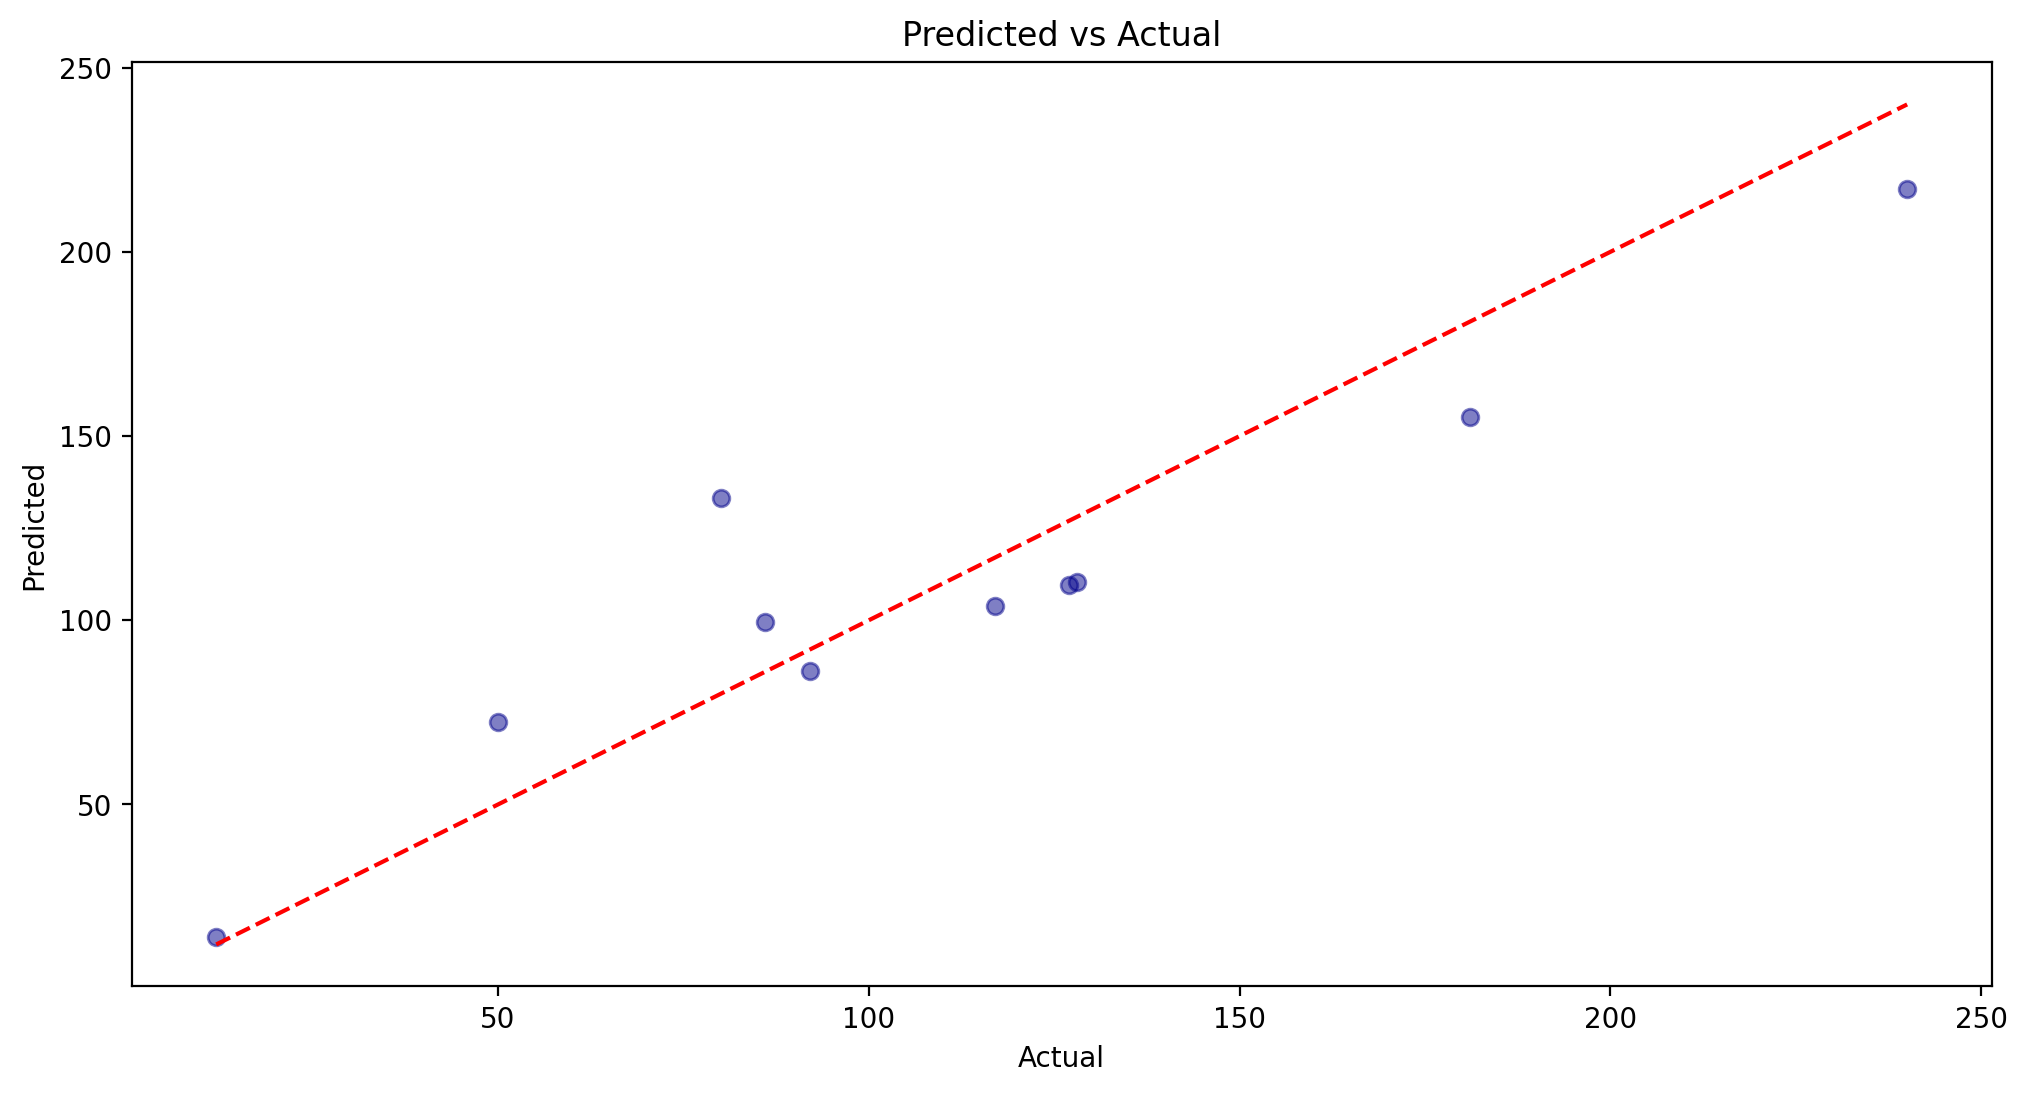

In [96]:
plt.figure(figsize=(12,6), dpi=200)
plt.scatter(y_test_exp.detach().numpy(), y_pred_exp.detach().numpy(), color='darkblue', alpha=0.5)
plt.plot([min(y_test_exp.detach().numpy()), max(y_test_exp.detach().numpy())], 
         [min(y_test_exp.detach().numpy()), max(y_test_exp.detach().numpy())], 
         color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.show()

### Deep Neural Network top prediction errors:

In [207]:
diff = np.abs(y_test.detach().numpy() - np.squeeze(y_pred_test.detach().numpy()))

results_nn = pd.DataFrame({'test_id': test_id,
                           'Actual': y_test.detach().numpy(), 
                           'Predicted': np.squeeze(y_pred_test.detach().numpy()), 
                           'Absolute Difference': diff})\
.sort_values('Absolute Difference', ascending=False).set_index('test_id')

Data points with the highest prediction errors:

In [293]:
results_nn.head(10)

,Actual,Predicted,Absolute Difference
test_id,,,
7187,230.0,60.742683,169.257324
14024,300.0,145.280548,154.719452
21392,30.0,174.796921,144.796921
20501,10.0,126.661362,116.661362
21098,15.0,126.875084,111.875084
6788,15.0,112.772995,97.772995
1748,15.0,109.290726,94.290726
8033,15.0,104.441010,89.441010
12961,95.0,180.282333,85.282333


In [209]:
bad_preds = df.reset_index().loc[results_nn.index]

In [294]:
bad_preds.head(10)

,beam_name,length,concrete_area,concrete_cover,steel_area,frp_area,insulation_thickness,insulation_depth,conc_strength,steel_strength,frp_strength,glass_transition,thermal_conductivity,specific_heat,total_load,load_ratio,fire_resistance
test_id,,,,,,,,,,,,,,,,,
7187,I2_ B2914,4720,140000,25,854.64,214.2,25.0,25.0,30.0,456,1068,85,0.094,816000,52.11,44.27,230
14024,I4_ B1303,1640,105000,38,379.84,263.9,19.0,114.0,29.0,416,1034,83,0.078,357000,127.10,44.40,300
21392,I5_ B4447,3940,157500,38,593.87,304.5,38.0,0.0,37.0,418,1034,85,0.167,264000,68.31,43.84,30
20501,I5_ B3556,1420,62500,25,213.88,19.8,38.0,25.0,40.0,440,4318,74,0.181,285000,54.82,33.14,10
21098,I5_ B4153,3900,120000,25,593.87,62.4,38.0,50.0,37.0,454,4100,83,0.190,300000,63.63,45.20,15
6788,I2_ B2515,4560,87500,38,395.91,42.5,25.0,38.0,28.0,458,4840,81,0.099,859000,31.04,45.74,15
1748,I1_ B1699,4900,135000,25,593.87,220.0,19.0,62.5,40.0,439,1100,82,0.168,607000,53.81,37.78,15
8033,I2_ B3760,2220,90000,25,379.84,180.0,38.0,62.5,40.0,448,1100,74,0.114,988000,99.05,41.73,15
12961,I3_ B4464,5580,157500,38,569.76,132.6,38.0,76.0,31.0,442,1138,88,0.048,366000,52.83,69.93,95


In [214]:
test_diff=pd.concat([bad_preds,
          results_nn[['Predicted', 'Absolute Difference']]], 
          axis=1)

In [295]:
test_diff.head()

,beam_name,length,concrete_area,concrete_cover,steel_area,frp_area,insulation_thickness,insulation_depth,conc_strength,steel_strength,frp_strength,glass_transition,thermal_conductivity,specific_heat,total_load,load_ratio,fire_resistance,Predicted,Absolute Difference
test_id,,,,,,,,,,,,,,,,,,,
7187,I2_ B2914,4720,140000,25,854.64,214.2,25.0,25.0,30.0,456,1068,85,0.094,816000,52.11,44.27,230,60.742683,169.257324
14024,I4_ B1303,1640,105000,38,379.84,263.9,19.0,114.0,29.0,416,1034,83,0.078,357000,127.10,44.40,300,145.280548,154.719452
21392,I5_ B4447,3940,157500,38,593.87,304.5,38.0,0.0,37.0,418,1034,85,0.167,264000,68.31,43.84,30,174.796921,144.796921
20501,I5_ B3556,1420,62500,25,213.88,19.8,38.0,25.0,40.0,440,4318,74,0.181,285000,54.82,33.14,10,126.661362,116.661362
21098,I5_ B4153,3900,120000,25,593.87,62.4,38.0,50.0,37.0,454,4100,83,0.190,300000,63.63,45.20,15,126.875084,111.875084


#### Distribution of the top 100 data points with the highest prediction errors:

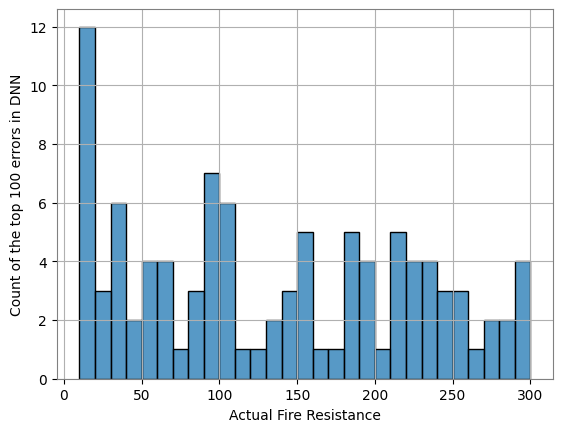

In [297]:
sns.histplot(data=pd.DataFrame(test_diff['fire_resistance'].head(100)),
             x='fire_resistance',
             binwidth=10)

ax = plt.gca()
ax.set_ylabel('Count of the top 100 errors in DNN')
ax.set_xlabel('Actual Fire Resistance')
ax.grid(True)
ax.spines['top'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')

#### Highest prediction errors for data with fire resistance between 95 to 110 minutes:

In [290]:
test_diff[test_diff['fire_resistance'].between(95,110)][['beam_name', 'total_load', 'concrete_cover', 'steel_area', 'insulation_depth', 'load_ratio',
                                                         'fire_resistance', 'Predicted', 'Absolute Difference']].head(5)

,beam_name,total_load,concrete_cover,steel_area,insulation_depth,load_ratio,fire_resistance,Predicted,Absolute Difference
test_id,,,,,,,,,
12961,I3_ B4464,52.83,38,569.76,76.0,69.93,95,180.282333,85.282333
6726,I2_ B2453,98.79,38,379.84,0.0,59.65,100,24.232883,75.767120
12960,I3_ B4463,45.76,38,569.76,76.0,57.39,100,166.551407,66.551407
20032,I5_ B3087,87.45,25,854.64,0.0,71.80,95,42.309753,52.690247
13957,I4_ B1236,62.34,25,593.87,25.0,71.25,105,59.592987,45.407013


---